# BERTモデルとWRIMEデータセットを用いた文章中の恋愛感情推定

## 研究説明
BERT × WRIME を用いた自然言語処理による感情構造の分析

## 概要
本ノートブックでは、WRIMEデータセットの8感情ラベルを用い、
BERTにより文章中の感情分布を推定し、
複数感情の重み付けによって「恋愛感情スコア」を定義・分析する。

感情という曖昧な対象を分解・構造化することで、
恋愛文と非恋愛文の違いを数値的に捉えることを目的としている。

詳細な説明は次セクションに示す。

## 1. 研究背景・目的
恋愛感情は喜び・期待・不安・恐れなど複数の感情が複雑に絡み合った、定義の曖昧な感情である。
既存の感情分析では単一ラベルで扱われることが多く、恋愛特有の感情構造を十分に表現できない課題がある。

本研究では、WRIMEデータセットに含まれる8感情ラベルを用い、
文章に含まれる複数感情の分布をもとに「恋愛感情スコア」を定義することで、
曖昧な感情を構造化・数値化できるかを検証することを目的とする。

## 2. 使用データ・モデル
- データセット：WRIME（日本語感情分析データセット）
- 使用モデル：bert-base-japanese-whole-word-masking
- 実装環境：Python / Google Colab

WRIMEは各文章に対して8種類の感情（喜び・悲しみ・期待・驚き・怒り・恐れ・嫌悪・信頼）が付与されており、複数感情を同時に扱える点が本研究の目的に適している。

## 3. 手法概要
1. BERTを用いて入力文章ごとの感情スコアを推定
2. 恋愛感情に寄与すると考えられる感情に重みを付与
3. 各感情スコアを加重平均し、恋愛感情スコアを算出
4. 文の種類（告白文・失恋文・風景描写文など）ごとに挙動を比較

感情という抽象的な対象をそのまま扱うのではなく、
「どの感情がどの程度寄与しているか」を分解して分析することを重視した。

## 4. 実装内容
- テキスト前処理
- BERTによる感情推定
- 感情スコアの正規化
- 恋愛感情スコアの算出
- 文例ごとの推定結果の可視化

各ステップでモデルの出力を確認し、想定と異なる結果が出た場合は原因を検討した。

## 5. 実験結果
告白文や恋愛に関する感情表現を含む文章では、
喜び・期待・信頼などのスコアが高くなり、恋愛感情スコアも高く算出される傾向が確認できた。

一方で、情景描写を中心とした文章に対しても負の感情スコアが反応するケースが見られ、恋愛感情とは無関係な文脈に対する誤判定が課題として残った。

## 6. 考察・課題
- 感情語が明示されない文章に対してもBERTが感情を推定してしまう傾向がある
- 特に風景描写文では、恋愛感情とは直接関係しない負の感情がスコアに影響する
- 感情スコアの重み付けが手動定義であり、最適化の余地がある

今後は、心理描写文と情景描写文を事前に分類する前処理や、重みを学習によって最適化する手法の導入を検討したい。

## 7. まとめ
本研究を通して、曖昧で感覚的に捉えられがちな感情も、分解・整理することで技術的に扱える可能性があることを確認した。
感情の構造を分析し、課題を言語化しながら改善を検討するプロセスは、今後、自然言語処理やデータ分析を用いた課題解決に活かせると考えている。

## 環境構築

In [1]:
!pip install -U transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 24.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.6
    Uninstalling transformers-4.57.6:
      Successfully uninstalled transformers-4.57.6


In [2]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 87.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 45.5 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=25d7e777595318ffef689bbb878a69379cdfecee8b2e9c4305bc87129a468e07
  Stored in directory: /root/.cache/pip/wheels/93/8b/55/dd5978a069678c372520847cf84ba2ec539cb41917c00a2206
Successfully built ipadic


In [3]:
import transformers
print(transformers.__version__)

5.0.0


In [4]:
import numpy as np
import pandas as pd

In [5]:
# Hugging Face (Transformers) 関連のモジュール
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset

### Matplotlibで日本語を使用できるようにする

In [6]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v310.json

# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 41 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 2s (4,622 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

In [7]:
!apt-get -y install fonts-ipafont-gothic
!pip install japanize-matplotlib
import japanize_matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'IPAPGothic'
japanize_matplotlib.japanize()


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-21ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=493a39ebf9c72d7576bc8ec4e3b514c480dac5e1f1606425a350c5b1adc065f7
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


Text(0.5, 1.0, '日本語を表示できるかテスト')

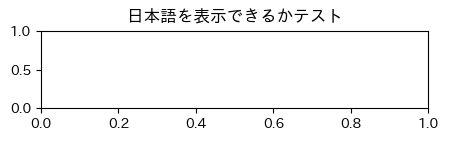

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

## データセットの準備

### WRIMEデータセットのダウンロード

In [9]:
# GitHubよりWRIMEデータをダウンロードする
#
# WRIME dataset : https://github.com/ids-cv/wrime
# 今回使用するのは ver1 （感情極性が付与されていない版）
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2026-02-02 02:49:45--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2026-02-02 02:49:47--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487235 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv’

wrime-ver1.tsv      100%[===================>]   9.05M  --.-KB/s    in 0.08s   

2026-02-02 02:49:47 (119 MB/s) - ‘wrime-ver1.tsv’ saved [9487235/9487235]



In [10]:
# pandas.DataFrameとして読み込む
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.head(2)

,Sentence,UserID,Datetime,Train/Dev/Test,Writer_Joy,Writer_Sadness,Writer_Anticipation,Writer_Surprise,Writer_Anger,Writer_Fear,...,Reader3_Disgust,Reader3_Trust,Avg. Readers_Joy,Avg. Readers_Sadness,Avg. Readers_Anticipation,Avg. Readers_Surprise,Avg. Readers_Anger,Avg. Readers_Fear,Avg. Readers_Disgust,Avg. Readers_Trust
0,ぼけっとしてたらこんな時間｡チャリあるから食べにでたいのに…,1,2012/07/31 23:48,train,0,1,2,1,1,0,...,1,0,0,2,0,0,0,0,0,0
1,今日の月も白くて明るい。昨日より雲が少なくてキレイな? と立ち止まる帰り道｡チャリなし生活も...,1,2012/08/02 23:09,train,3,0,3,0,0,0,...,0,1,1,0,0,2,0,0,0,0


### 前処理

__前提①：WRIMEデータセットのラベルは、各感情の強度__
- 各感情（例えば、Joy=喜）の強度を、0〜3の４段階でラベル付けしている
- ８つの感情全てにおいて、最頻ラベルは「0」


__前提②：WRIMEデータセットには、複数種類のラベルが付与されている__
1. Writer_*
    - 文章の __書き手__ が自身で付与したラベル。「主観感情」。
2. Reader{1,2,3}_* :
    - 文章の __読み手__ が付与したラベル。「客観感情」。３名分。
3. Avg.Readers_*
    - ３名分の客観感情の平均値。

問題設定
1. ８つの感情の、分類タスクとして扱う
    - 相対的にどの感情が強いかを推定する
    - データセットの本来の用途としては感情強度を推定するタスク。しかしながら、感情強度=0のサンプルが多く、やや扱いが難しいため、今回は簡素化して扱う。
2. 客観感情の平均値を使用する
    - 論文において、主観感情と客観感情は異なることが指摘されている
    - 主観感情は、書き手の性格や表現方法に依存する部分がある。そのため、客観感情、かつ、その平均値を用いることで、推定結果の納得感が高くなることが期待される

In [11]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

# readers_emotion_intensities 列を生成する
# "Avg. Readers_*" の値をlist化したもの
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が1以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 1)
df_wrime_target = df_wrime[is_target]

In [12]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))
print('test :', len(df_test))

train : 37599
test : 3012


## モデル(BERT)を訓練する

### Tokenizerで入力データに変換

In [13]:
!pip install unidic-lite fugashi[unidic-lite]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=a7d77d60fedacc3d736927e8b4f1d6091389e01e73f58a27eafebc61be4d063b
  Stored in directory: /root/.cache/pip/wheels/5e/1f/0f/4d43887e5476d956fae828ee9b6687becd5544d68b51ed633d
Successfully built unidic-lite


In [14]:
import unidic_lite
import fugashi

tagger = fugashi.Tagger()
print(tagger.parse("これはテストです。"))

これ	コレ	コレ	此れ	代名詞			0
は	ワ	ハ	は	助詞-係助詞			
テスト	テスト	テスト	テスト-test	名詞-普通名詞-サ変可能			1
です	デス	デス	です	助動詞	助動詞-デス	終止形-一般	
。			。	補助記号-句点			
EOS


In [15]:
# 使用するモデルを指定して、Tokenizerを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [16]:
# 前処理関数: tokenize_function
# 感情強度の正規化（総和=1）も同時に実施する
def tokenize_function(batch):
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

# Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 前処理（tokenize_function） を適用
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Parameter 'function'=<function tokenize_function at 0x7cc1e4133560> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/37599 [00:00<?, ? examples/s]

Map:   0%|          | 0/3012 [00:00<?, ? examples/s]

### 訓練済みモデルの読み込み

In [17]:
# 分類モデルのため AutoModelForSequenceClassification を使用する
# checkpoint と num_labels（クラス数） を指定する. 今回は、いずれも上で定義済み
# - checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
# - num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels)

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: cl-tohoku/bert-base-japanese-whole-word-masking
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the che

### 訓練を実行

In [18]:
# accuracyによる評価は今回の研究目的と合致しないため使用しない
# metric = load_metric("accuracy")
#
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     label_ids = np.argmax(labels, axis=-1)
#     return metric.compute(predictions=predictions, references=label_ids)


In [19]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    report_to=[],
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
)

trainer.train()


Step,Training Loss
500,0.319189
1000,0.285183
1500,0.272319
2000,0.269586
2500,0.265791
3000,0.262261
3500,0.254775
4000,0.253387
4500,0.248009


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

TrainOutput(global_step=4700, training_loss=0.26912384520185756, metrics={'train_runtime': 3834.8646, 'train_samples_per_second': 9.805, 'train_steps_per_second': 1.226, 'total_flos': 9893245506527232.0, 'train_loss': 0.26912384520185756, 'epoch': 1.0})

In [20]:
model.save_pretrained("my_model")
tokenizer.save_pretrained("my_model")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('my_model/tokenizer_config.json',
 'my_model/vocab.txt',
 'my_model/added_tokens.json')

In [21]:
!zip -r my_model.zip my_model
from google.colab import files
files.download("my_model.zip")

  adding: my_model/ (stored 0%)
  adding: my_model/tokenizer_config.json (deflated 75%)
  adding: my_model/model.safetensors (deflated 7%)
  adding: my_model/config.json (deflated 57%)
  adding: my_model/vocab.txt (deflated 49%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 訓練したモデルで推論する

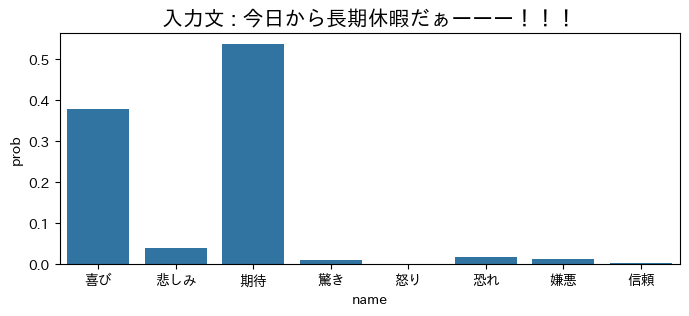

In [22]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# 動作確認
analyze_emotion('今日から長期休暇だぁーーー！！！', show_fig=True)

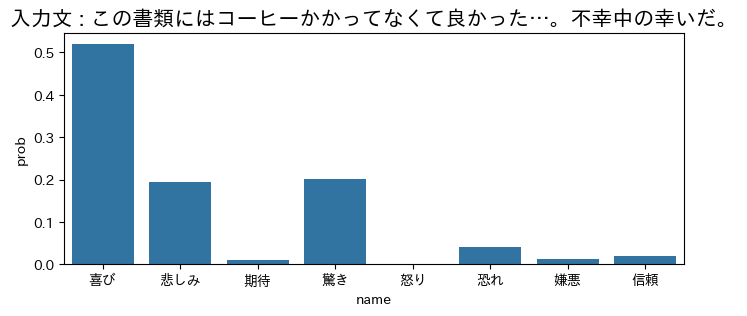

In [23]:
analyze_emotion('この書類にはコーヒーかかってなくて良かった…。不幸中の幸いだ。', show_fig=True)

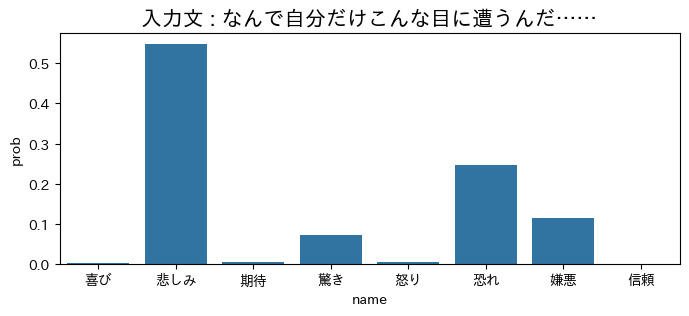

In [24]:
analyze_emotion('なんで自分だけこんな目に遭うんだ……', show_fig=True)

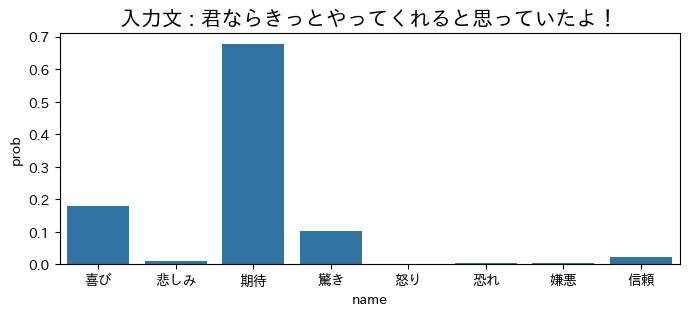

In [25]:
analyze_emotion('君ならきっとやってくれると思っていたよ！', show_fig=True)

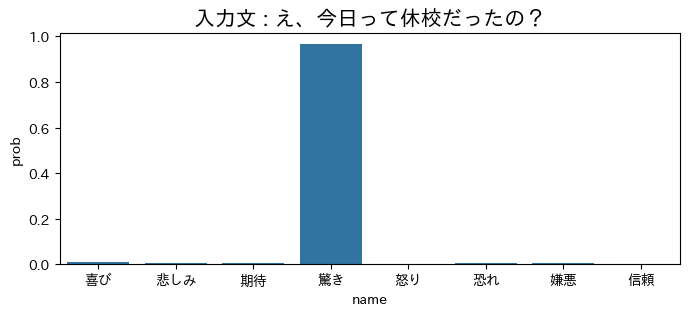

In [26]:
analyze_emotion('え、今日って休校だったの？', show_fig=True)

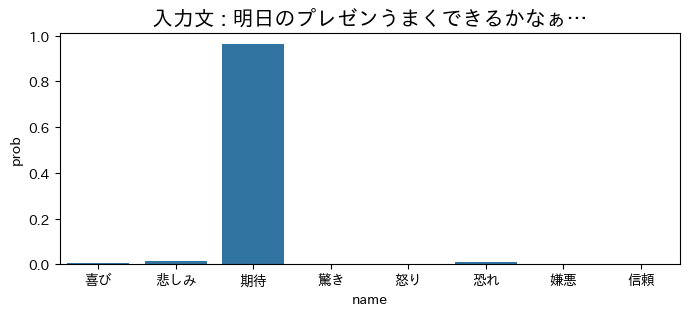

In [27]:
analyze_emotion('明日のプレゼンうまくできるかなぁ…', show_fig=True)

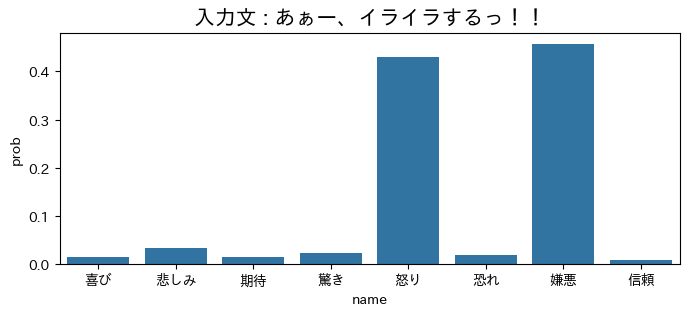

In [28]:
analyze_emotion('あぁー、イライラするっ！！', show_fig=True)

In [29]:
import re

def split_text_strict(text):
    # 改行をスペースに変換
    text = text.replace('\n', ' ').replace('\r', ' ')

    # 全角・半角スペースをすべて削除
    text = re.sub(r'[ 　]+', '', text)

    # 句点、感嘆符、疑問符で文を区切る
    sentences = re.split(r'(?<=[。！？])', text)

    # 空文字を除去
    return [s for s in sentences if s]

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns

In [31]:
def analyze_cumulative_emotion(text):
    # 文章を文ごとに分割
    sentences = split_text_strict(text)

    # 感情名（モデルと合わせておく）
    emotion_names = emotion_names_jp

    # 感情ごとの累積スコア初期化
    cumulative_scores = {emotion: 0.0 for emotion in emotion_names}

    # 各文に対して感情推定を実行して加算
    for sentence in sentences:
        scores = analyze_emotion(sentence, ret_prob=True)
        for emotion in emotion_names:
            cumulative_scores[emotion] += scores.get(emotion, 0.0)

    # データフレーム化
    df = pd.DataFrame(cumulative_scores.items(), columns=["感情", "累積スコア"])

    # グラフ描画
    plt.figure(figsize=(8, 4))
    sns.barplot(x="感情", y="累積スコア", data=df)
    plt.title("テキスト全体における感情の累積", fontsize=16)
    plt.ylabel("スコアの合計")
    plt.xlabel("感情")
    plt.tight_layout()
    plt.show()

    return df

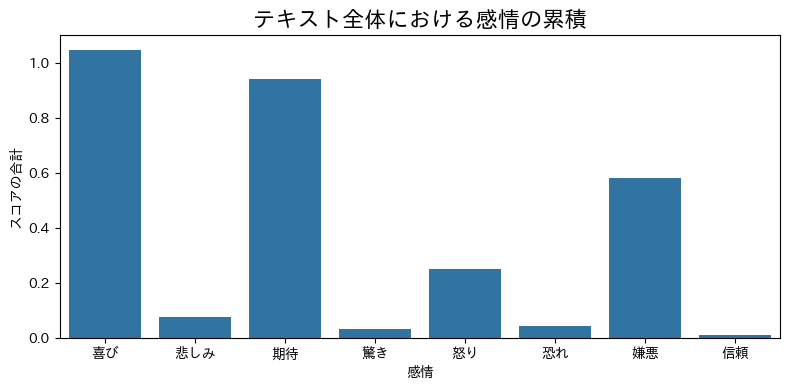

,感情,累積スコア
0,喜び,1.049879
1,悲しみ,0.077711
2,期待,0.943839
3,驚き,0.034206
4,怒り,0.252612
5,恐れ,0.044957
6,嫌悪,0.583950
7,信頼,0.012846


In [32]:
text = """
今日は朝からいい天気で、気分がとてもよかった。
でも帰り道で雨に降られてびしょ濡れになってしまい、ちょっとイライラした。
明日は晴れるといいな！
"""

analyze_cumulative_emotion(text)

In [33]:
text = """今日は朝から雨が降っていて、少し肌寒く感じた。
コーヒーを飲みながら、窓の外をぼんやりと眺めていると、
静かな時間が少しだけ心を落ち着かせてくれた。"""

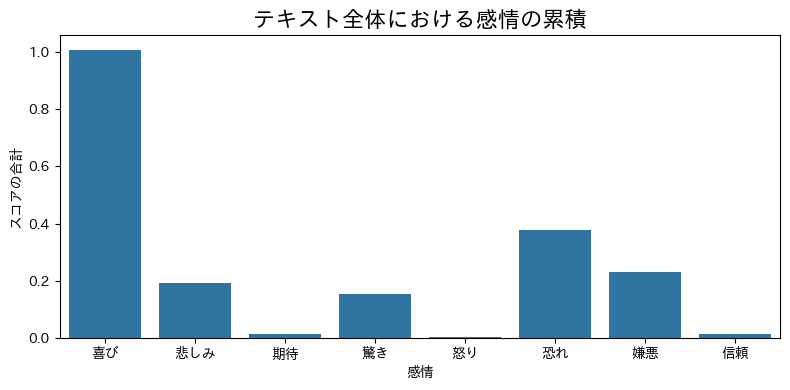

,感情,累積スコア
0,喜び,1.006770
1,悲しみ,0.193496
2,期待,0.016580
3,驚き,0.154228
4,怒り,0.003665
5,恐れ,0.378458
6,嫌悪,0.230251
7,信頼,0.016552


In [34]:
analyze_cumulative_emotion(text)

## 恋愛感情分析

In [35]:
# ==============================
# 💡 関数定義（感情分析 + 可視化）
# ==============================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 文分割関数 ---
def split_text_strict(text):
    """
    句点（。！？）または閉じ鉤括弧（」）で文を区切る。
    空白や改行も整え、空文は除去。
    """
    text = text.replace('\n', ' ').replace('\r', ' ')
    text = re.sub(r'[ 　]+', ' ', text)

    # 文末の句点か閉じ鉤括弧で区切る正規表現
    sentences = re.split(r'(?<=[。！？」])', text)

    # 空文・空白のみの要素を除去し、トリムして返す
    return [s.strip() for s in sentences if s.strip()]

# --- 文番号表示関数 ---
def print_numbered_sentences(text):
    """
    テキストを句点または閉じ鉤括弧で区切り、
    文番号をつけて1文ずつプリントする関数。
    """
    sentences = split_text_strict(text)

    for i, sentence in enumerate(sentences, 1):
        print(f"{i}: {sentence}")

# --- softmax関数 ---
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

# --- 感情推定関数 ---
def analyze_emotion(text, show_fig=False, ret_prob=False):
    model.eval()
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text, fontsize=15)

    if ret_prob:
        return out_dict

# --- 感情の順番とバレンス定義 ---
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']
VALENCE = {
    '喜び': +1,
    '悲しみ': -1,
    '期待': +0.5,
    '驚き':  0.0,
    '怒り': -1,
    '恐れ': -0.5,
    '嫌悪': -1,
    '信頼': +1
}

# --- 感情曲線と累積スコアの計算 ---
def analyze_full_emotion_curve(text):
    sentences = split_text_strict(text)
    transitions = []
    cumulative_valence = []
    total_valence = 0.0

    for sentence in sentences:
        scores = analyze_emotion(sentence, ret_prob=True)
        transitions.append(scores)
        val = sum(VALENCE[k] * scores[k] for k in emotion_names_jp)
        total_valence += val
        cumulative_valence.append(total_valence)

    return transitions, cumulative_valence, sentences

# --- グラフ描画 ---
def plot_full_emotion_curve(transitions, cumulative_valence, sentences):
    df = pd.DataFrame(transitions)
    df["文番号"] = range(1, len(df)+1)
    df = df.set_index("文番号")

    plt.figure(figsize=(14, 6))
    for emo in df.columns:
        plt.plot(df.index, df[emo], marker='o', label=emo)
    plt.title("感情曲線（8感情）", fontsize=14)
    plt.xlabel("文番号")
    plt.ylabel("感情スコア")
    plt.legend(ncol=4)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(14, 4))
    plt.plot(range(1, len(cumulative_valence)+1), cumulative_valence, color='crimson', marker='o')
    plt.title("累積恋愛感情スコアの推移", fontsize=14)
    plt.xlabel("文番号")
    plt.ylabel("スコア（正負）")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ---累積恋愛感情が減少した文章チェック---
def analyze_and_print_decreasing_valence(text):
    """
    テキストを文単位に感情分析し、累積恋愛感情スコアが減少した文の
    番号・内容・スコア遷移・感情スコアを表示する。
    """
    # 感情分析とスコア算出
    transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text)

    print("▼ 累積恋愛感情スコアが減少した文:\n")
    found = False

    for i in range(1, len(cumulative_valence)):
        if cumulative_valence[i] < cumulative_valence[i-1]:
            found = True
            print(f"[文{i+1}] {sentences[i]}")
            print(f"  累積スコア: {cumulative_valence[i-1]:.3f} → {cumulative_valence[i]:.3f}")
            print()

    if not found:
        print("（減少した箇所はありませんでした）")

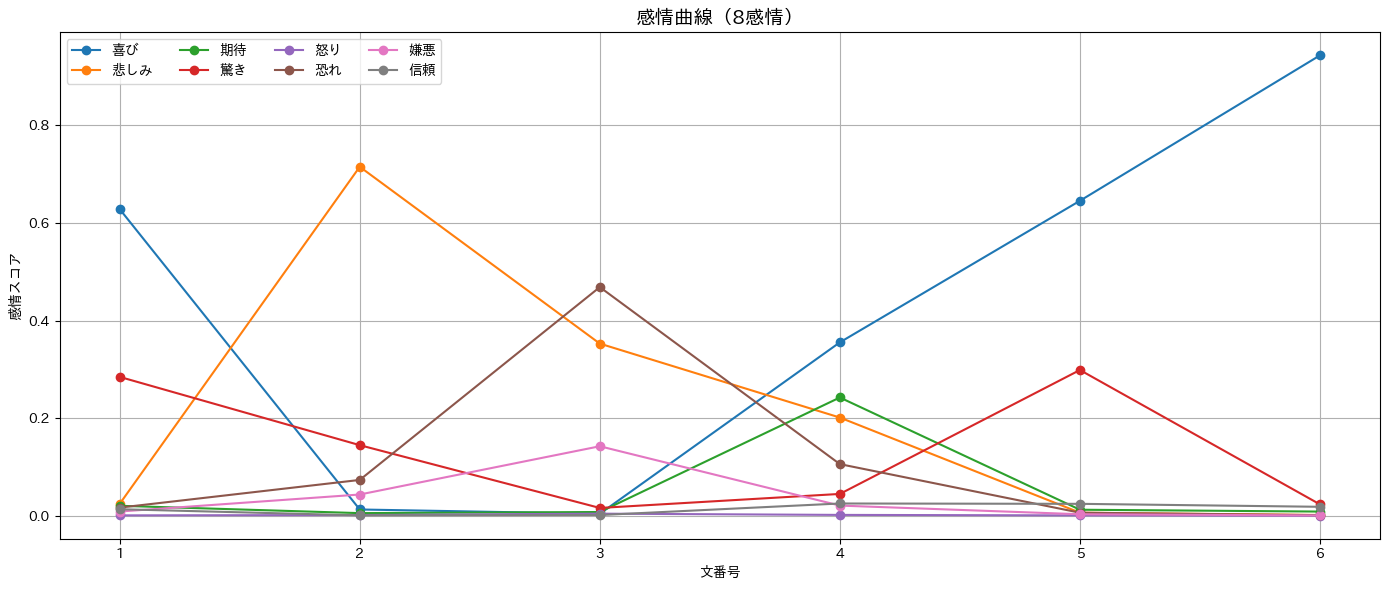

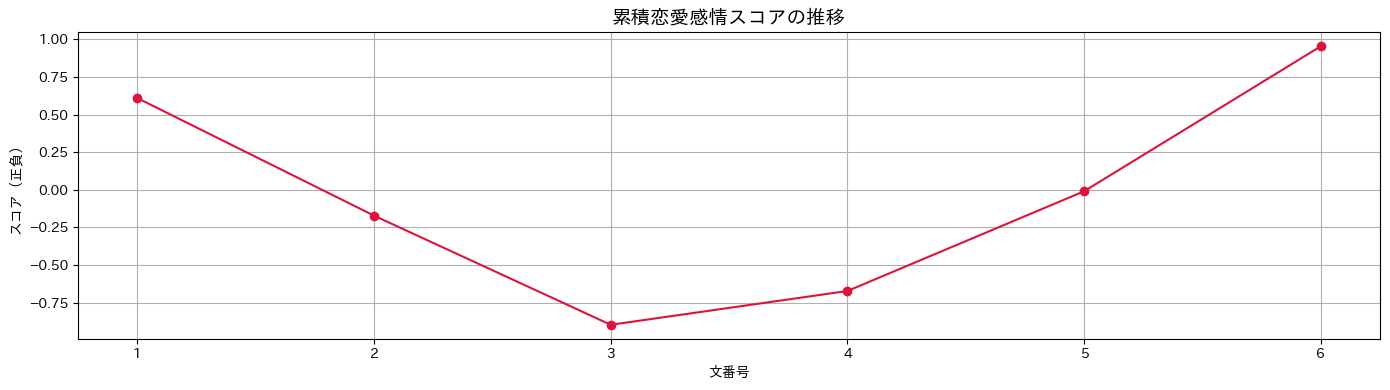

In [36]:
# --- 恋愛小説風のテキスト---
text = """
彼女からのメッセージが来るたびに、心が踊った。
しかしある日、返事がぱったりと来なくなった。
不安と恐れが胸を占め、怒りと悲しみが交錯した。
それでも、期待だけは捨てられず、彼女を待ち続けた。
数日後、彼女からの突然の電話に、喜びが爆発した。
優しい声を聞いた瞬間、信頼と愛情が再び蘇った。
"""

# --- 実行 ---
transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text)
plot_full_emotion_curve(transitions, cumulative_valence, sentences)

In [37]:
text1 = """校舎の屋上に、夕暮れの光が静かに差し込んでいた。
冷えた風が頬を撫で、二人の影を長く伸ばす。
彼は隣に立つ彼女を見た。沈黙がその場を支配していたが、互いの鼓動は確かに聞こえていた。
ゆっくりと、彼は口を開いた。
「話がある」
彼女は軽くうなずいた。目はじっと彼を捉えている。
彼は息を整え、言葉を選んでから続けた。
「長いあいだ、ずっと考えていた。君と過ごす時間が、自分にとってどれほど大切かを」
その言葉は、飾り気のない真摯なものだった。
彼女の瞳に、微かな光が宿った。
「私も同じ気持ちだった」
彼女の声は静かで、確かな響きを持っていた。
彼はゆっくりと彼女の手を取り、暖かさを感じた。
風がさらに強く吹き、夕陽が沈みかける空を朱に染めていた。
二人は言葉を交わすことなく、ただ見つめ合った。
その瞬間から、彼らは恋人となったのだ。"""

In [38]:
text2 = """校舎の屋上に、夕暮れの光が静かに差し込んでいた。
冷えた風が頬を撫で、二人の影を長く伸ばす。
彼は静かに彼女の前に立ち、決心を固めた声で切り出した。
「君に伝えたいことがある」
彼女は彼の言葉を待ち、わずかにうなずいた。
彼は続けた。
「長い間、考えていた。君のことを想う気持ちは本物だ」
だが、彼女の瞳はどこか遠くを見ていた。
しばらくの沈黙の後、彼女は静かに口を開いた。
「ありがとう。あなたの気持ちは嬉しいけれど、私にはまだ自分の気持ちがはっきりしないの」
「今は恋人になる覚悟ができていない」
彼はその言葉を受け止め、かすかな苦みを胸に刻んだ。
夕陽が沈み、校舎の影が長く伸びる。
二人は言葉を交わさず、それぞれの思いを胸に屋上を後にした。"""

In [39]:
print_numbered_sentences(text1)

1: 校舎の屋上に、夕暮れの光が静かに差し込んでいた。
2: 冷えた風が頬を撫で、二人の影を長く伸ばす。
3: 彼は隣に立つ彼女を見た。
4: 沈黙がその場を支配していたが、互いの鼓動は確かに聞こえていた。
5: ゆっくりと、彼は口を開いた。
6: 「話がある」
7: 彼女は軽くうなずいた。
8: 目はじっと彼を捉えている。
9: 彼は息を整え、言葉を選んでから続けた。
10: 「長いあいだ、ずっと考えていた。
11: 君と過ごす時間が、自分にとってどれほど大切かを」
12: その言葉は、飾り気のない真摯なものだった。
13: 彼女の瞳に、微かな光が宿った。
14: 「私も同じ気持ちだった」
15: 彼女の声は静かで、確かな響きを持っていた。
16: 彼はゆっくりと彼女の手を取り、暖かさを感じた。
17: 風がさらに強く吹き、夕陽が沈みかける空を朱に染めていた。
18: 二人は言葉を交わすことなく、ただ見つめ合った。
19: その瞬間から、彼らは恋人となったのだ。


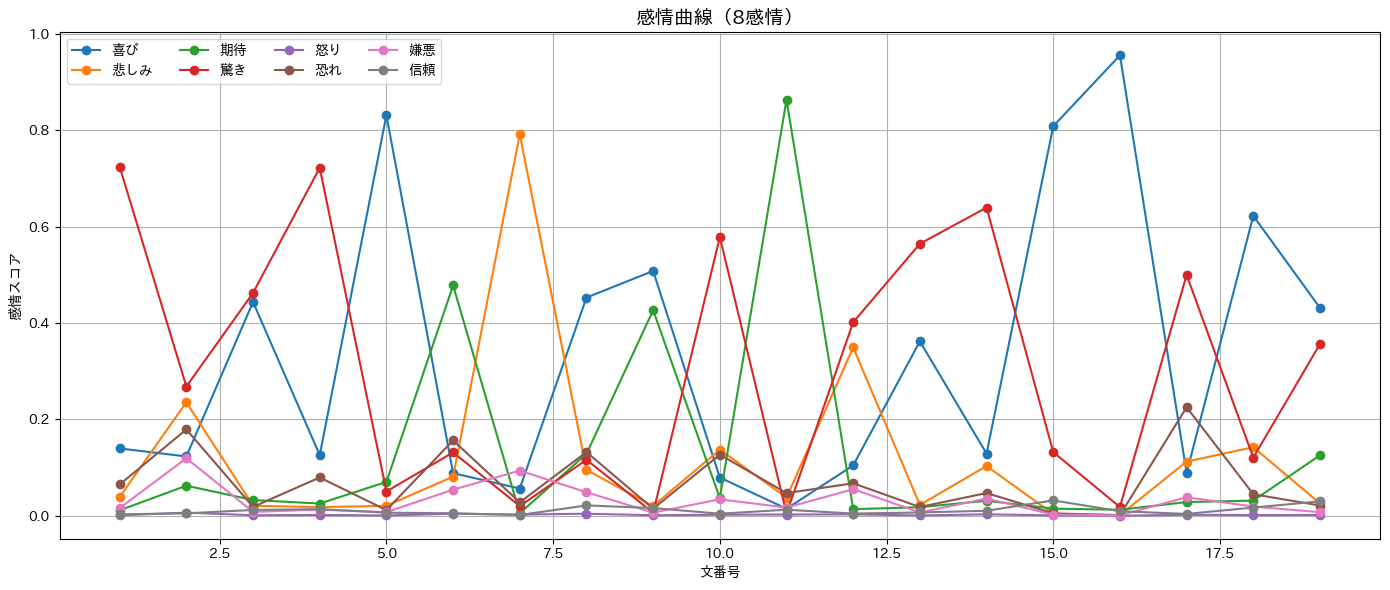

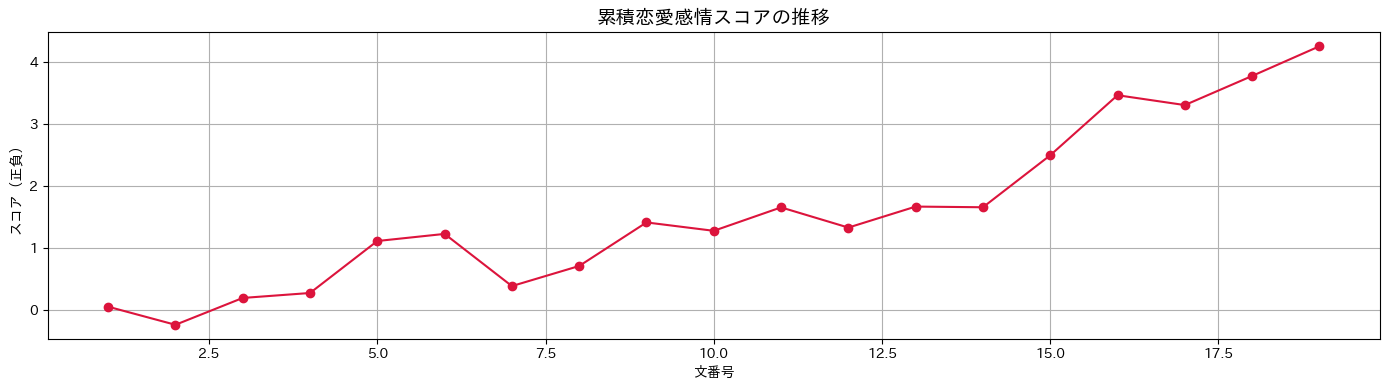

In [40]:
# --- 実行 ---
transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text1)
plot_full_emotion_curve(transitions, cumulative_valence, sentences)

In [41]:
analyze_and_print_decreasing_valence(text1)

▼ 累積恋愛感情スコアが減少した文:

[文2] 冷えた風が頬を撫で、二人の影を長く伸ばす。
  累積スコア: 0.060 → -0.232

[文7] 彼女は軽くうなずいた。
  累積スコア: 1.232 → 0.392

[文10] 「長いあいだ、ずっと考えていた。
  累積スコア: 1.417 → 1.282

[文12] その言葉は、飾り気のない真摯なものだった。
  累積スコア: 1.660 → 1.334

[文14] 「私も同じ気持ちだった」
  累積スコア: 1.673 → 1.662

[文17] 風がさらに強く吹き、夕陽が沈みかける空を朱に染めていた。
  累積スコア: 3.466 → 3.308



In [42]:
print_numbered_sentences(text2)

1: 校舎の屋上に、夕暮れの光が静かに差し込んでいた。
2: 冷えた風が頬を撫で、二人の影を長く伸ばす。
3: 彼は静かに彼女の前に立ち、決心を固めた声で切り出した。
4: 「君に伝えたいことがある」
5: 彼女は彼の言葉を待ち、わずかにうなずいた。
6: 彼は続けた。
7: 「長い間、考えていた。
8: 君のことを想う気持ちは本物だ」
9: だが、彼女の瞳はどこか遠くを見ていた。
10: しばらくの沈黙の後、彼女は静かに口を開いた。
11: 「ありがとう。
12: あなたの気持ちは嬉しいけれど、私にはまだ自分の気持ちがはっきりしないの」
13: 「今は恋人になる覚悟ができていない」
14: 彼はその言葉を受け止め、かすかな苦みを胸に刻んだ。
15: 夕陽が沈み、校舎の影が長く伸びる。
16: 二人は言葉を交わさず、それぞれの思いを胸に屋上を後にした。


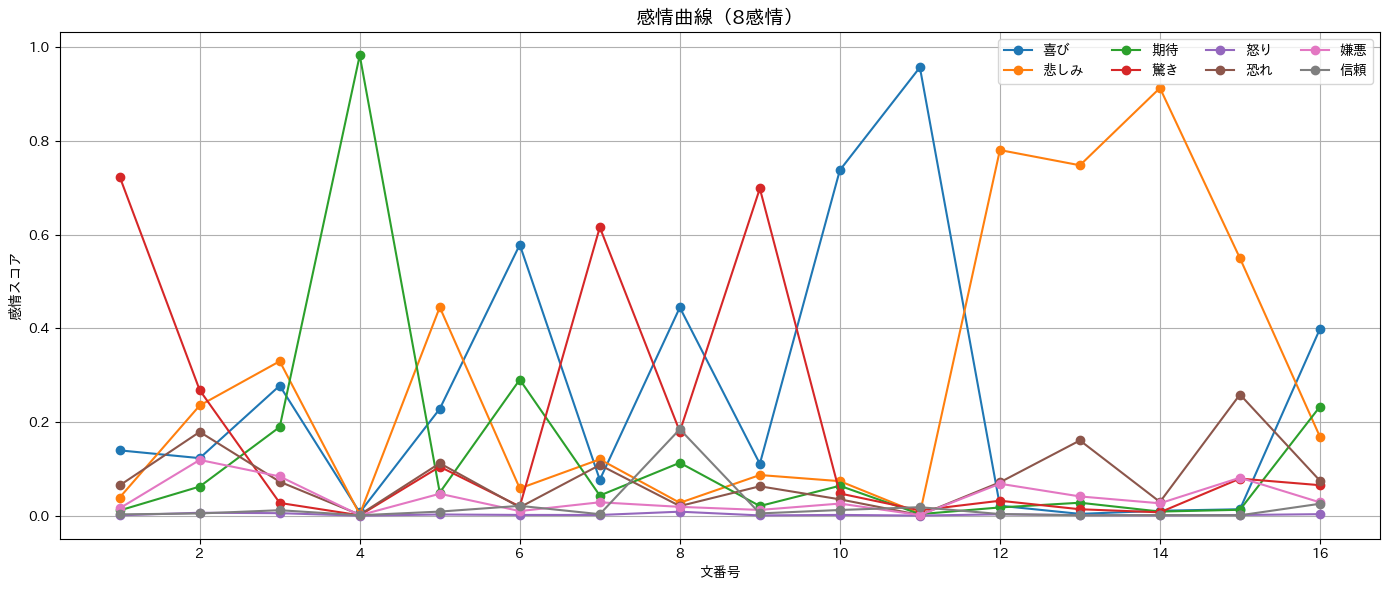

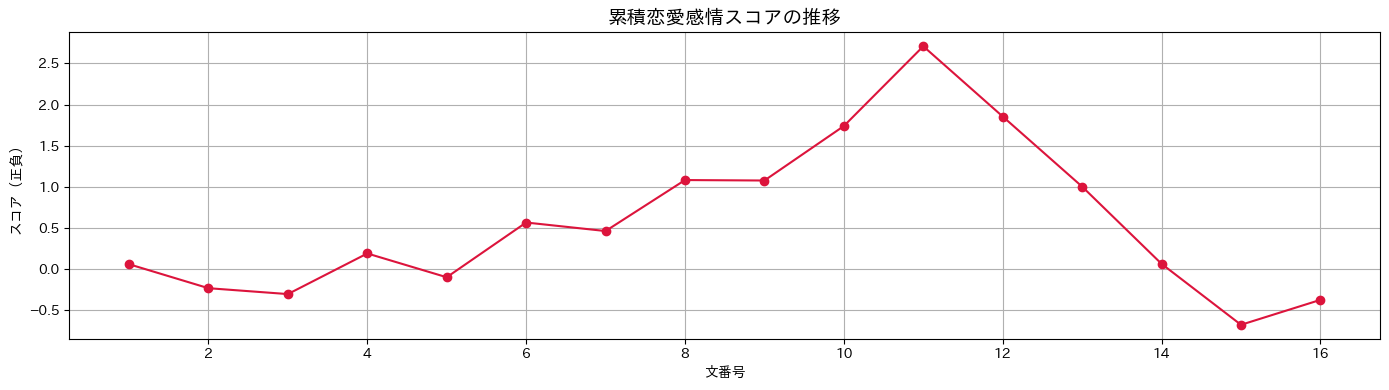

In [43]:
# --- 実行 ---
transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text2)
plot_full_emotion_curve(transitions, cumulative_valence, sentences)

In [44]:
analyze_and_print_decreasing_valence(text2)

▼ 累積恋愛感情スコアが減少した文:

[文2] 冷えた風が頬を撫で、二人の影を長く伸ばす。
  累積スコア: 0.060 → -0.232

[文3] 彼は静かに彼女の前に立ち、決心を固めた声で切り出した。
  累積スコア: -0.232 → -0.303

[文5] 彼女は彼の言葉を待ち、わずかにうなずいた。
  累積スコア: 0.190 → -0.099

[文7] 「長い間、考えていた。
  累積スコア: 0.567 → 0.463

[文9] だが、彼女の瞳はどこか遠くを見ていた。
  累積スコア: 1.083 → 1.077

[文12] あなたの気持ちは嬉しいけれど、私にはまだ自分の気持ちがはっきりしないの」
  累積スコア: 2.709 → 1.855

[文13] 「今は恋人になる覚悟ができていない」
  累積スコア: 1.855 → 1.003

[文14] 彼はその言葉を受け止め、かすかな苦みを胸に刻んだ。
  累積スコア: 1.003 → 0.064

[文15] 夕陽が沈み、校舎の影が長く伸びる。
  累積スコア: 0.064 → -0.677



In [45]:
def plot_multiple_cumulative_scores(text_list, labels=None):
    """
    複数の文章リストについて累積恋愛感情スコアを計算し、
    1つのグラフに重ねてプロットする。
    """
    plt.figure(figsize=(12, 6))

    if labels is None:
        labels = [f"テキスト{i+1}" for i in range(len(text_list))]

    for i, text in enumerate(text_list):
        _, cumulative_valence, _ = analyze_full_emotion_curve(text)
        x = list(range(1, len(cumulative_valence)+1))
        plt.plot(x, cumulative_valence, marker='o', label=labels[i])

    plt.title("複数文章の累積恋愛感情スコア推移比較")
    plt.xlabel("文番号")
    plt.ylabel("累積恋愛感情スコア")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

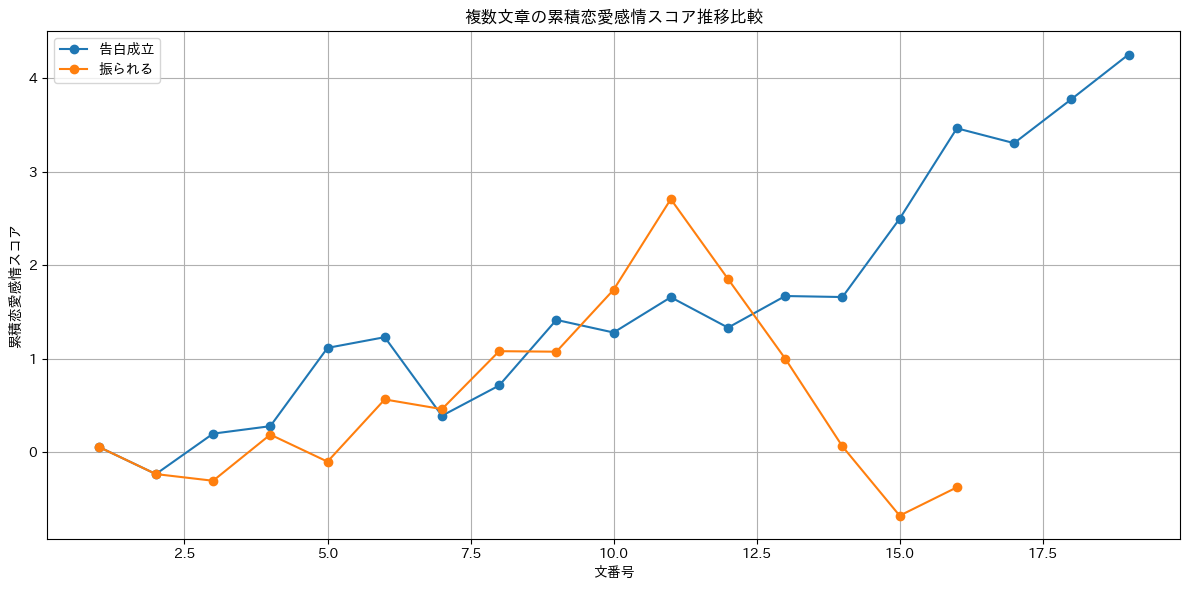

In [46]:
texts = [text1, text2]

# ラベル
labels = ["告白成立", "振られる"]

# 関数呼び出し
plot_multiple_cumulative_scores(texts, labels)

In [47]:
text3 = """学校を出ると、風が乾いていた。
雲がいくつか浮かび、陽射しはまだ夏の名残を引いていたけれど、風の端には季節が折れる気配があった。

道端に咲くムクゲの花が、小さく揺れている。
いくつか落ちた花が、地面に色の跡を残していた。

信号の手前で、彼女が待っていた。

「……思ったより、早かったね」

「プリント配られなかった。だから」

それだけ言って、鞄を肩にかけ直す。
鞄の金具がわずかに音を立てた。歩き出すまで、ふたりは黙っていた。

舗装路には、昨日の雨の痕がまだ残っていた。
場所によっては乾いていない箇所もある。
彼はそれを避けるでもなく歩く。
水面が光を跳ね返し、足音が微かに変わった。

ふたりの歩幅は、ときどきずれた。
歩道が狭いところでは、自然と順番が入れ替わった。
どちらも気にするそぶりは見せなかった。

自転車のタイヤが通り過ぎ、水がアスファルトに落ちる。
彼はその音に目を向け、彼女は気づかず前を見ていた。

「今日、遠くで雷鳴ってた」

彼女が言った。

「雷？」

「うん。帰りの空で、ちょっと。音だけだけど」

彼はうなずいたように見えたが、はっきりとはしなかった。
代わりに、空を見上げた。雲は、さっきより流れていた。

電柱に、尾の長い名前を知らない鳥がとまっていた。
カラスではなかった。

どこかの庭先から、沈丁花のような香りが漂ってきた。
春でも秋でもない、季節の端の匂い。

「右、曲がるんだったよね」

彼女の言葉に、彼は少し遅れてうなずいた。

曲がり角の塀には、苔が貼りついていた。
ひとつの蔦が、塀の上から垂れて風に揺れていた。

もうすぐ、分かれ道が来る。

けれど、それを言葉にしようとは思わなかった。
言葉にすることのほうが、不自然に感じた。

「今朝さ、駅のとこで猫が寝てた」

「猫？」

「うん。看板の裏にいた。茶色いやつ」

彼女はそう言って、前髪を風からかばうように指先で押さえた。
指のかたちが、ほんの少し残った。

「その猫、前にも見た気がする」

「前って、いつ？」

「ずっと前。寒くなる前」

風が少し強くなり、落ち葉が舞った。
そのとき、雲の隙間から陽射しがのぞいた。
ふたりの影が足元に差し、長く並んで揺れていた。

分かれ道まで、あと十数歩。
彼女の鞄が少し傾いているのに気づいたが、彼は何も言わなかった。

足が止まる。

「じゃあ、また」

「うん」

言葉は、それだけだった。
どちらも振り返らなかった。
影が別々の方向へと伸びていく。

その背中に、何もなかったわけではない。
"""

In [48]:
print_numbered_sentences(text3)

1: 学校を出ると、風が乾いていた。
2: 雲がいくつか浮かび、陽射しはまだ夏の名残を引いていたけれど、風の端には季節が折れる気配があった。
3: 道端に咲くムクゲの花が、小さく揺れている。
4: いくつか落ちた花が、地面に色の跡を残していた。
5: 信号の手前で、彼女が待っていた。
6: 「……思ったより、早かったね」
7: 「プリント配られなかった。
8: だから」
9: それだけ言って、鞄を肩にかけ直す。
10: 鞄の金具がわずかに音を立てた。
11: 歩き出すまで、ふたりは黙っていた。
12: 舗装路には、昨日の雨の痕がまだ残っていた。
13: 場所によっては乾いていない箇所もある。
14: 彼はそれを避けるでもなく歩く。
15: 水面が光を跳ね返し、足音が微かに変わった。
16: ふたりの歩幅は、ときどきずれた。
17: 歩道が狭いところでは、自然と順番が入れ替わった。
18: どちらも気にするそぶりは見せなかった。
19: 自転車のタイヤが通り過ぎ、水がアスファルトに落ちる。
20: 彼はその音に目を向け、彼女は気づかず前を見ていた。
21: 「今日、遠くで雷鳴ってた」
22: 彼女が言った。
23: 「雷？
24: 」
25: 「うん。
26: 帰りの空で、ちょっと。
27: 音だけだけど」
28: 彼はうなずいたように見えたが、はっきりとはしなかった。
29: 代わりに、空を見上げた。
30: 雲は、さっきより流れていた。
31: 電柱に、尾の長い名前を知らない鳥がとまっていた。
32: カラスではなかった。
33: どこかの庭先から、沈丁花のような香りが漂ってきた。
34: 春でも秋でもない、季節の端の匂い。
35: 「右、曲がるんだったよね」
36: 彼女の言葉に、彼は少し遅れてうなずいた。
37: 曲がり角の塀には、苔が貼りついていた。
38: ひとつの蔦が、塀の上から垂れて風に揺れていた。
39: もうすぐ、分かれ道が来る。
40: けれど、それを言葉にしようとは思わなかった。
41: 言葉にすることのほうが、不自然に感じた。
42: 「今朝さ、駅のとこで猫が寝てた」
43: 「猫？
44: 」
45: 「うん。
46: 看板の裏にいた。
47: 茶色いやつ」
48: 彼女はそう言って、前髪を風からかばうように指先で押さえた。
49: 指のか

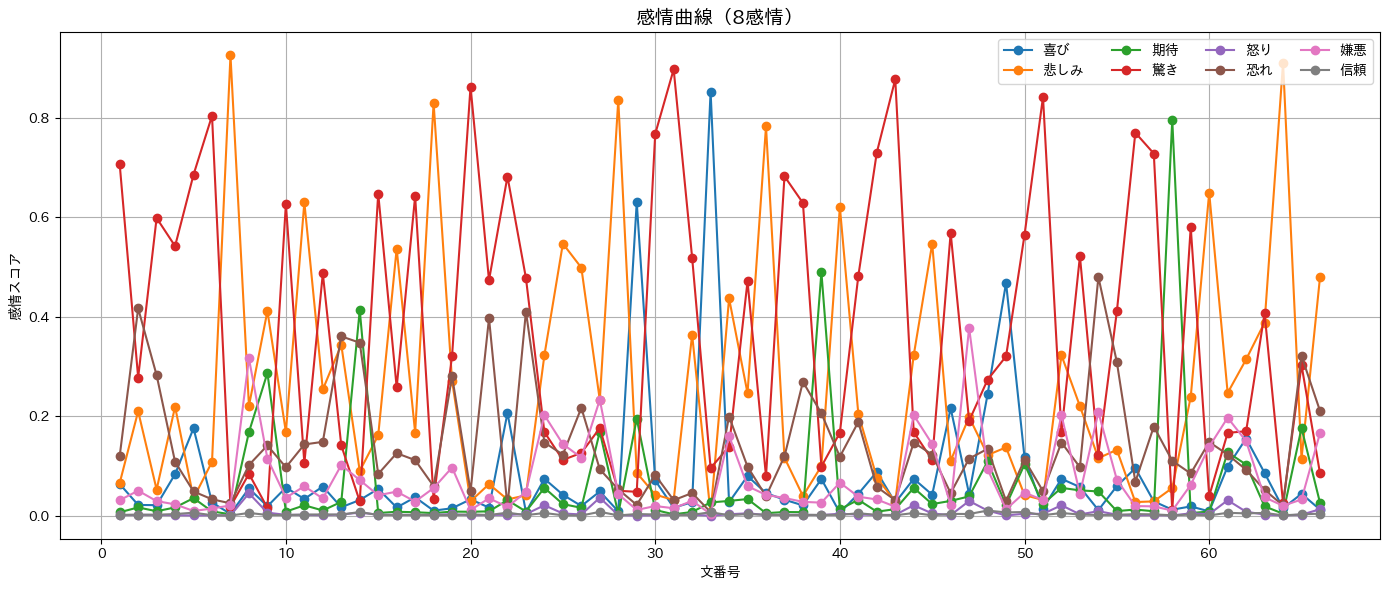

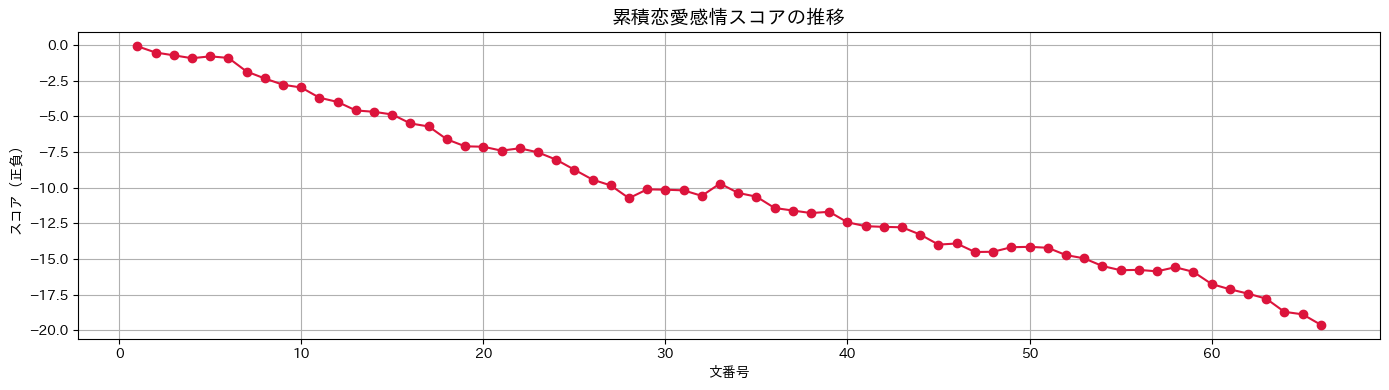

In [49]:
# --- 実行 ---
transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text3)
plot_full_emotion_curve(transitions, cumulative_valence, sentences)

In [50]:
analyze_and_print_decreasing_valence(text3)

▼ 累積恋愛感情スコアが減少した文:

[文2] 雲がいくつか浮かび、陽射しはまだ夏の名残を引いていたけれど、風の端には季節が折れる気配があった。
  累積スコア: -0.089 → -0.528

[文3] 道端に咲くムクゲの花が、小さく揺れている。
  累積スコア: -0.528 → -0.725

[文4] いくつか落ちた花が、地面に色の跡を残していた。
  累積スコア: -0.725 → -0.927

[文6] 「……思ったより、早かったね」
  累積スコア: -0.798 → -0.907

[文7] 「プリント配られなかった。
  累積スコア: -0.907 → -1.860

[文8] だから」
  累積スコア: -1.860 → -2.349

[文9] それだけ言って、鞄を肩にかけ直す。
  累積スコア: -2.349 → -2.788

[文10] 鞄の金具がわずかに音を立てた。
  累積スコア: -2.788 → -2.981

[文11] 歩き出すまで、ふたりは黙っていた。
  累積スコア: -2.981 → -3.698

[文12] 舗装路には、昨日の雨の痕がまだ残っていた。
  累積スコア: -3.698 → -3.995

[文13] 場所によっては乾いていない箇所もある。
  累積スコア: -3.995 → -4.590

[文14] 彼はそれを避けるでもなく歩く。
  累積スコア: -4.590 → -4.686

[文15] 水面が光を跳ね返し、足音が微かに変わった。
  累積スコア: -4.686 → -4.875

[文16] ふたりの歩幅は、ときどきずれた。
  累積スコア: -4.875 → -5.503

[文17] 歩道が狭いところでは、自然と順番が入れ替わった。
  累積スコア: -5.503 → -5.714

[文18] どちらも気にするそぶりは見せなかった。
  累積スコア: -5.714 → -6.616

[文19] 自転車のタイヤが通り過ぎ、水がアスファルトに落ちる。
  累積スコア: -6.616 → -7.107

[文20] 彼はその音に目を向け、彼女は気づかず前を見ていた。
  累積スコア: -7.107 → -7.134

[文21] 「今日、遠くで雷鳴ってた」
  累積スコア: -7.13

In [51]:
text4 = """自転車を押して坂を下ると、空気がしっとりしていた。
朝に降った雨が、まだアスファルトに匂いを残している。遠くでカエルの声がした。

道の端に、水たまりがところどころ残っていた。そこを避けるようにして歩く。
前を歩いている彼は、気にせずそのまま進む。靴の裏が、水を吸って、少し黒くなっていた。

声をかけるには近すぎて、かけないには遠すぎる距離。
それを保ちながら、ふたりはずっと坂を下っていた。

「雨、また降りそうだね」

彼が言った。

「うん」

短く返す。いつもそう。言いたいことはもっとあるのに、出てくるのは単語だけ。

前髪が少し濡れていた。乾きかけのその隙間から、白い首筋がちらりと見えた。
目をそらした。

風が、葉を揺らしている。濡れた木の匂いがする。
この季節の風は、名前をつけたくなるほどやさしいのに、あとに何も残さない。

彼がふと足を止めた。小さな橋の手前で。

「見て。川、増えてる」

川の水が、いつもより高い位置まできていた。雨のせいだろう。
彼はじっと見ていた。流れの速さを、目で追っている。

私は彼を見ていた。彼の目線がどこに向いていても、私はそれをなぞっている。

何を話せばいいかわからないまま、また歩き出す。
小さな音を立てて、自転車のブレーキが鳴る。何も言われないけど、合わせて歩くのが少しだけうれしかった。

途中、小さな草が道をはみ出して伸びていた。
花が咲くでもない、名もない草。でも、ちゃんと生きている。

それを見ながら、思った。私の気持ちも、あんなふうにどこかに伸びていけたらいい。誰にも気づかれなくても。

交差点の手前で、彼は右へ、自分はまっすぐ。
それはいつも通りで、変える理由もない。

「じゃあね」

「また」

背中を見送る。信号が変わるまで、その姿は消えなかった。

自転車のハンドルを握り直したとき、手のひらが少し湿っていた。
それが雨のせいなのか、それとも自分のせいなのか、よくわからなかった。"""

In [52]:
print_numbered_sentences(text4)

1: 自転車を押して坂を下ると、空気がしっとりしていた。
2: 朝に降った雨が、まだアスファルトに匂いを残している。
3: 遠くでカエルの声がした。
4: 道の端に、水たまりがところどころ残っていた。
5: そこを避けるようにして歩く。
6: 前を歩いている彼は、気にせずそのまま進む。
7: 靴の裏が、水を吸って、少し黒くなっていた。
8: 声をかけるには近すぎて、かけないには遠すぎる距離。
9: それを保ちながら、ふたりはずっと坂を下っていた。
10: 「雨、また降りそうだね」
11: 彼が言った。
12: 「うん」
13: 短く返す。
14: いつもそう。
15: 言いたいことはもっとあるのに、出てくるのは単語だけ。
16: 前髪が少し濡れていた。
17: 乾きかけのその隙間から、白い首筋がちらりと見えた。
18: 目をそらした。
19: 風が、葉を揺らしている。
20: 濡れた木の匂いがする。
21: この季節の風は、名前をつけたくなるほどやさしいのに、あとに何も残さない。
22: 彼がふと足を止めた。
23: 小さな橋の手前で。
24: 「見て。
25: 川、増えてる」
26: 川の水が、いつもより高い位置まできていた。
27: 雨のせいだろう。
28: 彼はじっと見ていた。
29: 流れの速さを、目で追っている。
30: 私は彼を見ていた。
31: 彼の目線がどこに向いていても、私はそれをなぞっている。
32: 何を話せばいいかわからないまま、また歩き出す。
33: 小さな音を立てて、自転車のブレーキが鳴る。
34: 何も言われないけど、合わせて歩くのが少しだけうれしかった。
35: 途中、小さな草が道をはみ出して伸びていた。
36: 花が咲くでもない、名もない草。
37: でも、ちゃんと生きている。
38: それを見ながら、思った。
39: 私の気持ちも、あんなふうにどこかに伸びていけたらいい。
40: 誰にも気づかれなくても。
41: 交差点の手前で、彼は右へ、自分はまっすぐ。
42: それはいつも通りで、変える理由もない。
43: 「じゃあね」
44: 「また」
45: 背中を見送る。
46: 信号が変わるまで、その姿は消えなかった。
47: 自転車のハンドルを握り直したとき、手のひらが少し湿っていた。
48: それが雨のせいなのか、それとも自分のせ

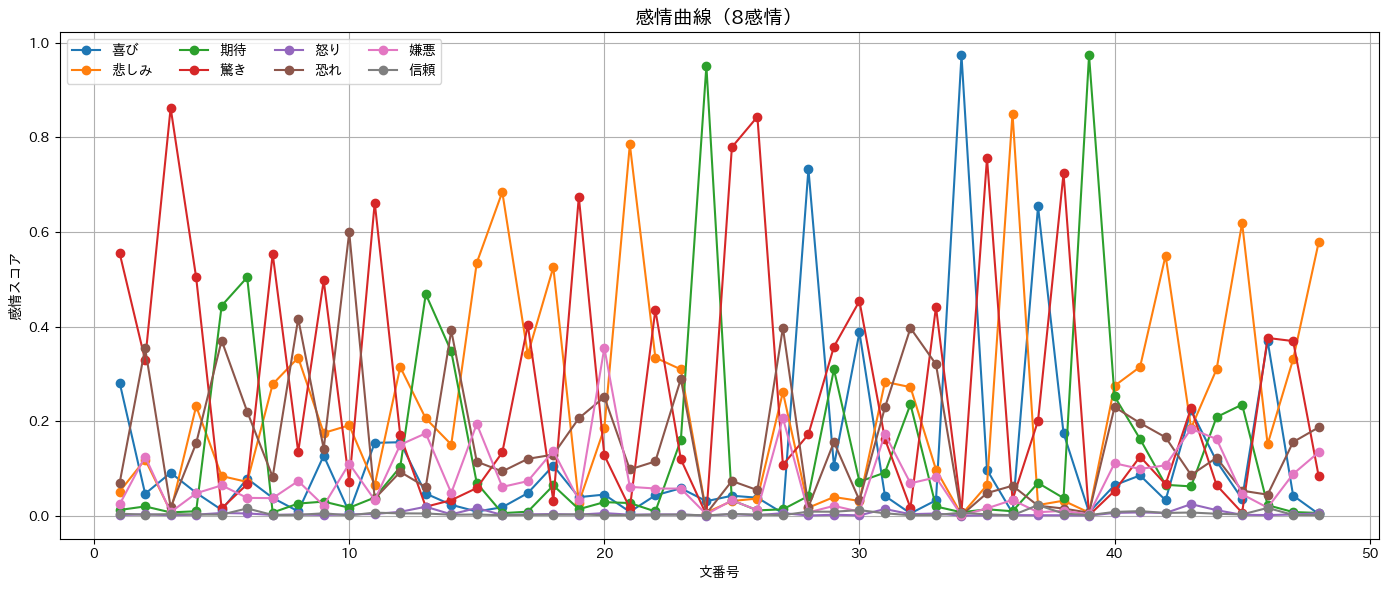

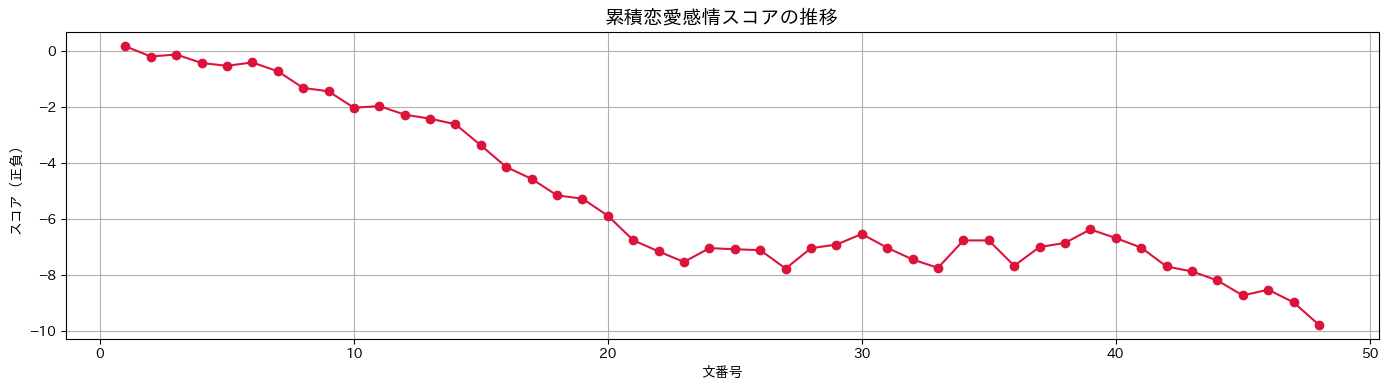

In [53]:
# --- 実行 ---
transitions, cumulative_valence, sentences = analyze_full_emotion_curve(text4)
plot_full_emotion_curve(transitions, cumulative_valence, sentences)

In [54]:
analyze_and_print_decreasing_valence(text4)

▼ 累積恋愛感情スコアが減少した文:

[文2] 朝に降った雨が、まだアスファルトに匂いを残している。
  累積スコア: 0.181 → -0.185

[文4] 道の端に、水たまりがところどころ残っていた。
  累積スコア: -0.114 → -0.416

[文5] そこを避けるようにして歩く。
  累積スコア: -0.416 → -0.518

[文7] 靴の裏が、水を吸って、少し黒くなっていた。
  累積スコア: -0.397 → -0.712

[文8] 声をかけるには近すぎて、かけないには遠すぎる距離。
  累積スコア: -0.712 → -1.307

[文9] それを保ちながら、ふたりはずっと坂を下っていた。
  累積スコア: -1.307 → -1.429

[文10] 「雨、また降りそうだね」
  累積スコア: -1.429 → -2.016

[文12] 「うん」
  累積スコア: -1.956 → -2.263

[文13] 短く返す。
  累積スコア: -2.263 → -2.407

[文14] いつもそう。
  累積スコア: -2.407 → -2.605

[文15] 言いたいことはもっとあるのに、出てくるのは単語だけ。
  累積スコア: -2.605 → -3.362

[文16] 前髪が少し濡れていた。
  累積スコア: -3.362 → -4.134

[文17] 乾きかけのその隙間から、白い首筋がちらりと見えた。
  累積スコア: -4.134 → -4.557

[文18] 目をそらした。
  累積スコア: -4.557 → -5.147

[文19] 風が、葉を揺らしている。
  累積スコア: -5.147 → -5.264

[文20] 濡れた木の匂いがする。
  累積スコア: -5.264 → -5.875

[文21] この季節の風は、名前をつけたくなるほどやさしいのに、あとに何も残さない。
  累積スコア: -5.875 → -6.749

[文22] 彼がふと足を止めた。
  累積スコア: -6.749 → -7.152

[文23] 小さな橋の手前で。
  累積スコア: -7.152 → -7.525

[文25] 川、増えてる」
  累積スコア: -7.031 → -7.072

[文26] 川の水が、いつも